# Breast Cancer Segmentation Using Transformers

- **Semantic segmentation** เป็นการทำนายที่ต้องการนำภาพมาและแบ่งประเภทของแต่ละพิกเซลในภาพ Semantic segmentation มีประโยชน์และถูกนำมาใช้ในหลากหลายแอพพลิเคชั่น เช่น การตัดแบ่งภาพถ่ายทางการแพทย์ และรถยนจ์ขับเคลื่อนอัจฉริยะ ยกตัวอย่างเช่น ในกรณีของรถส่งพิซซ่าอัจโนมัติ การนำ semantic segmentation มาช่วยจะสามารถไกด์ให้รถยังขับอยู่บนทางเท้าได้ ไม่ขับเข้าไปในบริเวณที่ผิดพลาดได้ (ดูตัวอย่างจาก https://huggingface.co/blog/fine-tune-segformer)

- วิธีการเก็บข้อมูลของ Semantic segmentation ปกติ จะทำการเก็บภาพที่เราสนใจมาเป็นข้อมูลตั้งต้น จากนั้นใช้ image labeling tools เช่น [Segments.ai](https://segments.ai/) หรือ [CVAT](https://github.com/opencv/cvat) ในการเก็บข้อมูลพิกเซลชนิดต่างๆ (บางครั้งเรียก "mask") ในการใช้เป็น label ในการเทรน แต่ในตัวอย่างนี้เราจะใช้ชุดข้อมูลภาพถ่ายอัลตราซาวน์ (ultrasound) ของเต้านม เพื่อตรวจจับเนื้องอกหรือมะเร็งเต้านม

- โดยการทำงานของโมเดลจะนำภาพมาทำการทำนายและสรุปว่าแต่ละ pixel ควรเป็นประเภทใด เช่น พื้นหลัง, เนื้องอก, หรือมะเร็ง โดยในกรณีนี้เราจะนำโมเดล [Segformer](https://huggingface.co/docs/transformers/model_doc/segformer) มา fine-tune สำหรับการตรวจจับบริเวณต่างๆที่อาจเป็น เนื้องอก (benign) หรือเนื้อร้าย (malignant) จากภาพถ่ายอัลตราซาวน์ โดยในที่นี้เราจะใช้โมเดลที่ขนาดเล็กที่สุดของ Segformer นั่นคือ `MiT-b0` มาทดลอง fine-tune เพื่อตัดแบ่งภาพของเรา

- สำหรับการวัดผลของ Segmentation ส่วนมากจะใช้ Dice Score (เท่ากับ 2 x Overlapped Area / (Actual Area + Predicted Are) ) หรือ Intersection over union (IoU, เท่ากับ Overlapped Area / Union of actual area and predicted area)

- ตัวอย่างนี้จะแบ่งเป็นการเตรียมข้อมูลที่โหลดมาได้จาก Kaggle, การนำโมเดล Segformer มา fine-tune, และจากนั้นคือการนำโมเดลไปทำนายผลจากภาพใน validation set


Reference: https://huggingface.co/blog/fine-tune-segformer

In [15]:
!pip install kaggle
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install transformers[torch]

## Download Data

In [16]:
# อัพโหลด kaggle.json ที่หาได้จาก https://www.kaggle.com/settings (ไปที่หน้านี้แล้วกด "Create New Token" ใน section API)
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset
!unzip breast-ultrasound-images-dataset.zip

 92% 180M/195M [00:01<00:00, 171MB/s]
100% 195M/195M [00:01<00:00, 184MB/s]
Archive:  breast-ultrasound-images-dataset.zip
  inflating: Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104).png  
  infl

In [17]:
from transformers import SegformerForSemanticSegmentation
from transformers import SegformerFeatureExtractor
from transformers import TrainingArguments, Trainer
from torchvision.transforms import ColorJitter, Resize, Compose

import torch
from torch import nn
import evaluate
import datasets
from datasets import Dataset, Features
import numpy as np

import os.path as op
from glob import glob
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
import os

In [18]:
paths = glob("Dataset_BUSI_with_GT/*/*")  # get all folders: normal, benign, malignant
im_paths = [path for path in paths if "_mask" not in path]
data_paths = []

# สร้าง dictionary ที่รวม image path, masking path, และ class name
for path in im_paths:
    class_name = Path(path).parent.name
    seg_path = Path(Path(path).parent, Path(path).stem + "_mask.png")
    if op.exists(seg_path):
        data_paths.append({
            "img": path,
            "seg": str(seg_path),
            "class": class_name
        })
print("Length of image and segmentation paths = ", len(data_paths))

Length of image and segmentation paths =  780


In [19]:
# list of dictionary to dictionary of each list
data_paths = {
    "img": [p["img"] for p in data_paths],
    "seg": [p["seg"] for p in data_paths],
    "class": [p["class"] for p in data_paths]
}

# convert ระหว่าง id <-> lable name
id2label = {0:"background", 1: "benign", 2: "malignant"}
label2id = {v: k for k, v in id2label.items()}

In [20]:
ds = Dataset.from_dict(data_paths, features=Features(
    {"img": datasets.Image(),
     "seg": datasets.Image(),
     "class": datasets.Value(dtype='string', id=None)}))

# train test split
ds_split = ds.train_test_split(test_size=0.2)

In [21]:
train_ds = ds_split["train"]
test_ds = ds_split["test"]

In [22]:
feature_extractor = SegformerFeatureExtractor()

# กำหนด transformsที่ต้องการ
_transforms = Compose([
    ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1),
])

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [23]:
def train_transforms(example_batch):
    '''
    pipeline ในการ transfrom train data
    ถ้าเป็น mask ของ class benign จะให้value = 1
    และถ้าเป็น class malignant จะเป็น value = 2
    และลด channel ให้เหลือ 1 channel
    '''
    images = [_transforms(x) for x in example_batch["img"]]
    labels = []
    for segim, cls in zip(example_batch["seg"], example_batch["class"]):
        segim = np.array(segim).astype(int)
        if cls == "benign":
          segim[segim == 1] = 1
        elif cls == "malignant":
          segim[segim == 1] = 2
        else:
          pass
        if len(segim.shape) == 3:
          segim = segim[:, :, 0]
        labels.append(segim)
    inputs = feature_extractor(images, labels)
    return inputs

def val_transforms(example_batch):
    images = [x for x in example_batch["img"]]
    labels = []
    for segim, cls in zip(example_batch["seg"], example_batch["class"]):
        segim = np.array(segim).astype(int)
        if cls == "benign":
          segim[segim == 1] = 1
        elif cls == "malignant":
          segim[segim == 1] = 2
        else:
          pass
        if len(segim.shape) == 3:
          segim = segim[:, :, 0]
        labels.append(segim)
    inputs = feature_extractor(images, labels)
    return inputs

input function สำหรับ transfrom data

In [24]:
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

function ที่ใช้ในการ evaluate

In [25]:
num_labels = len(id2label)
metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
    '''
    process สำหรับการ evaluate ผลลัพธ์ ที่ทำนายจากโมเดล
    '''
    # ไม่ต้องคิด gradient
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()

        # คำนวน evaluation metric
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False,
        )
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key] = value.tolist()
        return metrics

## Download a Pretrained Model and Train It

In [26]:
# สร้างโมเดลจาก pretrain model
pretrained_model_name = "nvidia/mit-b0"
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_fuse.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.bias', 'decode_head.linear

In [27]:
save_path = "segformer-breast-cancer_30ep"

เทรน 30  epochs

In [28]:
os.environ["WANDB_DISABLED"] = "true"

n_epochs = 30

training_args = TrainingArguments(
    output_dir= save_path,
    learning_rate=6e-5,
    num_train_epochs=n_epochs,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=300,
    eval_steps=300,
    logging_steps=1,
    eval_accumulation_steps=5,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()
feature_extractor.save_pretrained(save_path)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Per Category Iou,Per Category Accuracy
300,0.180500,0.207105,0.563584,0.650218,0.945108,"[0.9522910214628129, 0.35597900507094016, 0.38248337122310894]","[0.9844119296714371, 0.4803877884345996, 0.48585527883746626]"
600,0.152000,0.162783,0.604853,0.713426,0.947683,"[0.9525706140330837, 0.4258345563794154, 0.43615323108476856]","[0.9791855052811275, 0.5975566139521575, 0.5635362311699621]"
900,0.043500,0.151741,0.628168,0.708019,0.954531,"[0.9580944032975929, 0.4604088037923396, 0.46600137880435566]","[0.9878961064559273, 0.6007323005025066, 0.5354272765687837]"
1200,0.078100,0.146854,0.648438,0.743815,0.955529,"[0.9586950345597687, 0.46937472529471586, 0.5172430492953498]","[0.983367143662574, 0.5959896339391627, 0.652088757114403]"
1500,0.035200,0.153306,0.647511,0.747619,0.954053,"[0.9565895254437337, 0.47311257865553547, 0.5128303326014411]","[0.9806451753285087, 0.5658362591574818, 0.6963768026680048]"
1800,0.100400,0.157909,0.658462,0.733171,0.958309,"[0.9603114527087526, 0.4867013048043347, 0.5283727513095081]","[0.9881126634523039, 0.5895808868674706, 0.6218209122610078]"
2100,0.020100,0.161642,0.654843,0.734376,0.957776,"[0.9603979053980308, 0.47884308927633784, 0.5252888038447846]","[0.9872288158312638, 0.5836944664667767, 0.632204579889383]"


Trainer is attempting to log a value of "[0.9522910214628129, 0.35597900507094016, 0.38248337122310894]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9844119296714371, 0.4803877884345996, 0.48585527883746626]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9525706140330837, 0.4258345563794154, 0.43615323108476856]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9791855052811275, 0.5975566139521575, 0.5635362311699621]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocatio

['segformer-breast-cancer_30ep/preprocessor_config.json']

## Inference
ทดลองใช้จริง โดยการเตรียมข้อมูลจะคล้ายกับการเตรียมข้อมูลสำหรับเทรนโมเดล

In [38]:
# [optional] copy preprocessor_config.json to the model path folder
!cp segformer-breast-cancer_30ep/preprocessor_config.json segformer-breast-cancer_30ep/checkpoint-2100/preprocessor_config.json

In [30]:
print(save_path)
model_path = f"{save_path}/checkpoint-2100"
image_processor = feature_extractor.from_pretrained(f"{save_path}/preprocessor_config.json", local_files_only=True)
model = SegformerForSemanticSegmentation.from_pretrained(f"{model_path}",id2label=id2label, label2id=label2id, local_files_only=True)

segformer-breast-cancer_30ep


/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [31]:
ds = Dataset.from_dict(data_paths, features=Features(
    {"img": datasets.Image(),
     "seg": datasets.Image(),
     "class": datasets.Value(dtype='string', id=None)}))
ds_split = ds.train_test_split(test_size=0.2)
train_ds = ds_split["train"]
test_ds = ds_split["test"]

(-0.5, 605.5, 604.5, -0.5)

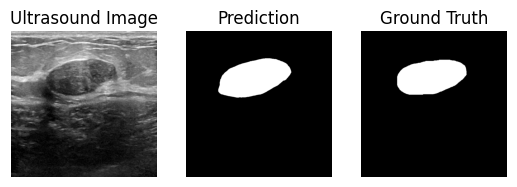

In [32]:
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

image = test_ds[22]['img']
gt_seg = test_ds[22]['seg']

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

upsampled_logits = nn.functional.interpolate(
    logits,
    size=(image.size[1], image.size[0]),
    mode="bilinear",
    align_corners=False,
)
pred_seg = upsampled_logits.argmax(dim=1)[0]

plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Ultrasound Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(pred_seg, cmap="gray")
plt.title("Prediction")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(gt_seg, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

In [33]:
image = Image.open("./Dataset_BUSI_with_GT/benign/benign (1).png")
gt = Image.open("./Dataset_BUSI_with_GT/benign/benign (1)_mask.png")

In [34]:
from transformers import pipeline

segmenter = pipeline("image-segmentation", model=model_path)
segmenter(image)

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


[{'score': None,
  'label': 'background',
  'mask': <PIL.Image.Image image mode=L size=562x471 at 0x7F821418A500>},
 {'score': None,
  'label': 'benign',
  'mask': <PIL.Image.Image image mode=L size=562x471 at 0x7F8210DC6C20>}]

In [35]:
encoding = feature_extractor(image, return_tensors="pt")
pixel_values = encoding.pixel_values

outputs = model(pixel_values=pixel_values)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

In [36]:
def ade_palette():
  """Creates a label colormap used in ADE20K segmentation benchmark.
  Returns:
    A colormap for visualizing segmentation results.
  """
  return np.asarray([
      [0, 0, 0],
      [120, 120, 80],
      [140, 140, 140],
      [204, 5, 255],
      [230, 230, 230],
  ])

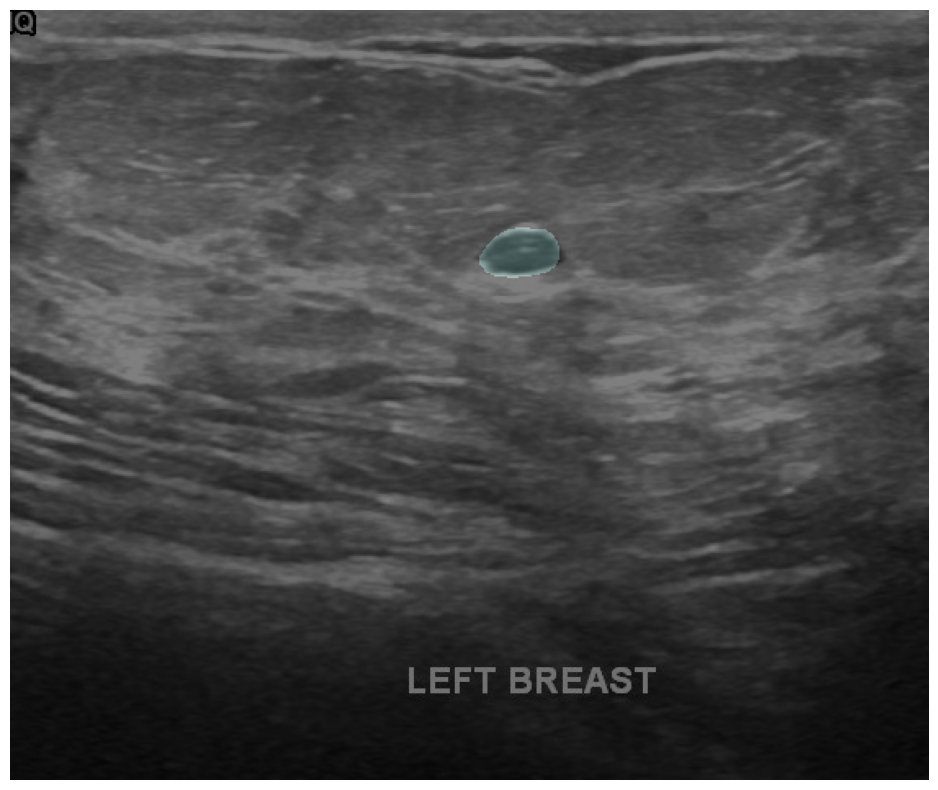

In [37]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[pred_seg == label, :] = color
color_seg = color_seg[..., ::-1]  # convert to BGR

img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

**ผู้จัดเตรียม code ใน tutorial**: ดร. ฐิติพัทธ อัชชะกุลวิสุทธิ์ และ Peeranut Buabang